In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *
import mujoco
from lqr import *


  0%|          | 0/100 [00:00<?, ?it/s]

[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
[[0.         0.         0.        ]
 [0.1267109  0.1267109  0.04817109]
 [0.15497067 0.15497067 0.00417393]
 [0.15497067 0.15497067 0.00417393]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.6]]


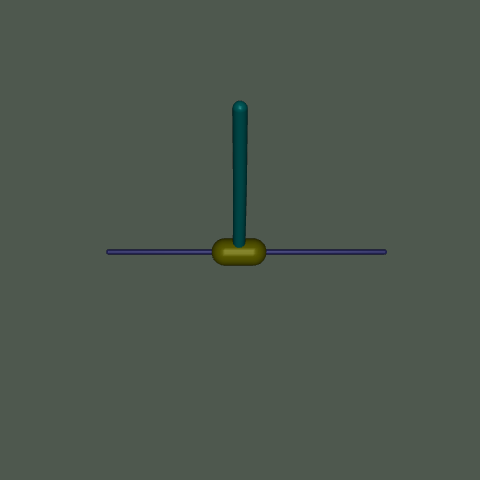

In [3]:
# Test environment
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

# Get properties of the pendulum
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
I = env.model.body_inertia
print(m)
print(l)
print(lcm)
print(I)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)
print(env.model.body_pos)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

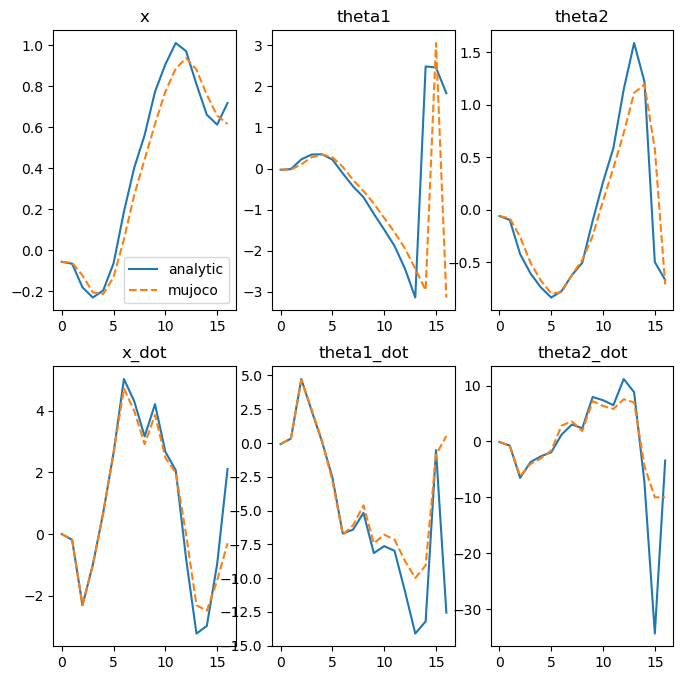

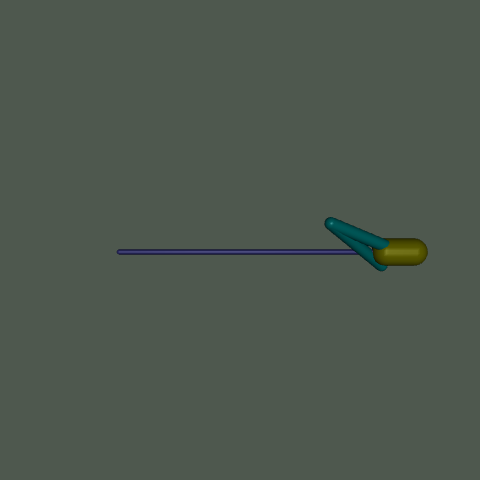

In [10]:
## Let's test to see if your analytic dynamics matches the simulator

frames = []  # frames to create animated png
frames.append(env.render())

# Total time steps
T = 16

# First let's generate a random control sequence
control_sequence = np.random.randn(T, 1)

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state, _ = env.reset()

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    full_states_mujoco, _, _, _, _ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic = torch.zeros((T+1, 1, 6))
states_analytic[0] = change_of_coords(start_state)
for t in range(T):
    states_analytic[t + 1] = dynamics_analytic(states_analytic[t], torch.from_numpy(control_sequence[t]))

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(states_analytic[:, 1])
axes[0][1].plot(states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(states_analytic[:, 2])
axes[0][2].plot(states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(states_analytic[:, 3])
axes[1][0].plot(states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:, 4])
axes[1][1].plot(states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[1][2].plot(states_analytic[:, 5])
axes[1][2].plot(states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [13]:
# simulation parameters
Tf = 0.5
dt = 0.05
N = int(Tf/dt + 1)
num_iterations = 4
mu = 10e-6
mu_delta = 2

# LQR parameters
# set the desired state (xstar), should be the goal state
# will will be linearizing about this point
xstar = torch.zeros((6,))
# set the Q and R matrices
# TODO: tune the Q, R amd Qf matrices
Q = torch.diag(torch.tensor([0.5, 1.0, 2.0, 0.5, 0.5, 0.5]))
R = 0.5*torch.tensor([1])
Qf = 1000 * torch.eye(6)

/Users/marcovaldez/Downloads/DoublePendulum/pendulum.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454847243/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor([x, th1, th2, xdot, th1dot, th2dot])


Text(0.5, 0, 'time (s)')

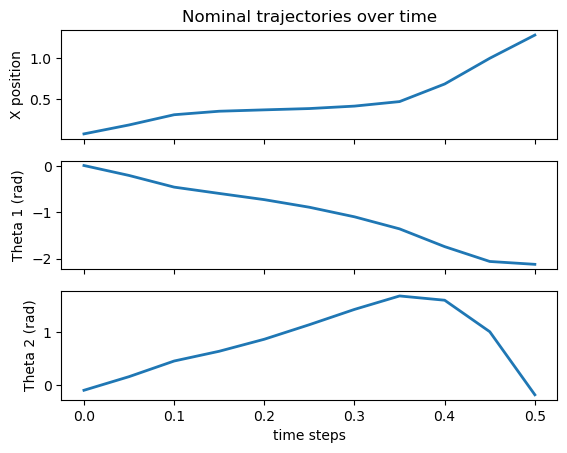

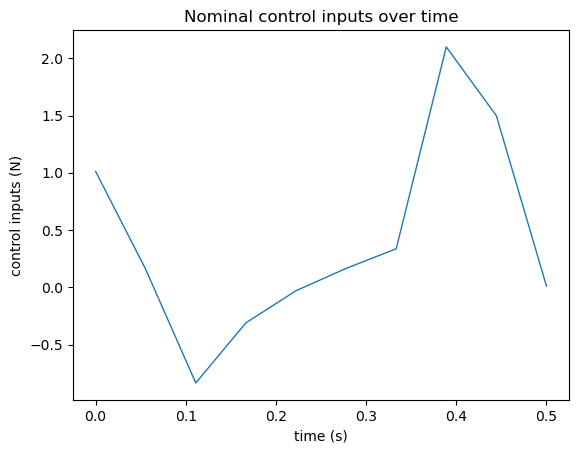

In [12]:
# perform rollouts to obtain the nominal state and control trajectories
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state,_ = env.reset()

# start the nominal state trajectory at the initial state from env
init_state = start_state[:8].reshape(8,1)
xs_nom, us_nom = rollout_dynamics(N, init_state)

# plot the nominal trajectory over time
t_vec = np.linspace(0, Tf, N)
fig, axs = plt.subplots(3,1,sharex=True)
lin0, = axs[0].plot(t_vec, xs_nom[:,0], lw=2) 
lin1, = axs[1].plot(t_vec, xs_nom[:,1], lw=2)
lin2, = axs[2].plot(t_vec, xs_nom[:,2], lw=2)
axs[0].set_title('Nominal trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("time steps")  

# plot the nominal control trajectory
plt.figure()
t_vec = np.linspace(0, Tf, N-1)
lin0, = plt.plot(t_vec, us_nom[:,0], lw=1)
plt.title('Nominal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("time (s)")

/Users/marcovaldez/Downloads/DoublePendulum/lqr.py:73: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454847243/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  lu = ((curr_u).T @ R.T).reshape(1,1)


Text(0.5, 0, 'time (s)')

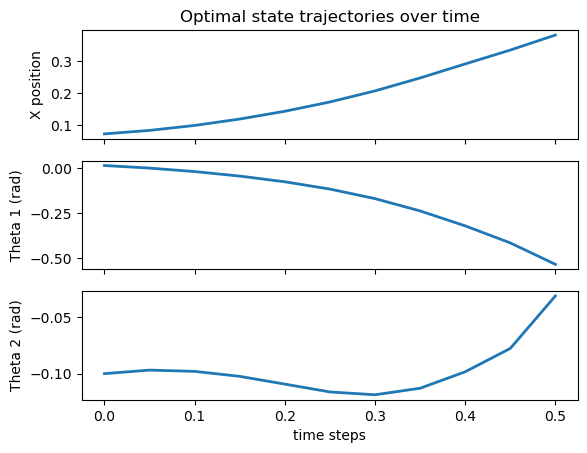

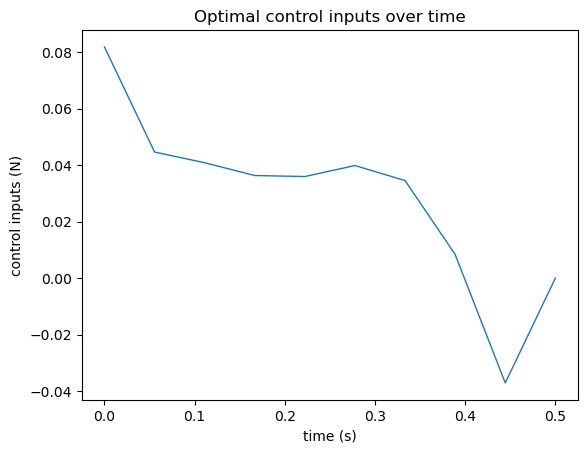

In [14]:
## perform iLQR
# run loop until convergence is reached
i = 0

xs = xs_nom
us = us_nom

while i < num_iterations:
    # perform the backwards pass
    ks, Ks = backward_pass(xs, us, xstar, Q, R, mu, mu_delta)

    # perform the forward pass
    us, xs = forward_pass(ks, Ks, N, xs, us)

    i += 1

# plot the optimal state trajectory over time
t_vec_x = np.linspace(0, Tf, N)
fig, axs = plt.subplots(3,1,sharex=True)
lin0, = axs[0].plot(t_vec_x, xs[:,0], lw=2) 
lin1, = axs[1].plot(t_vec_x, xs[:,1], lw=2)
lin2, = axs[2].plot(t_vec_x, xs[:,2], lw=2)
axs[0].set_title('Optimal state trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("time steps")  

# plot the optimal control trajectory
plt.figure()
t_vec_u = np.linspace(0,Tf,N-1)
lin0, = plt.plot(t_vec_u, us[:,0], lw=1)
plt.title('Optimal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("time (s)")


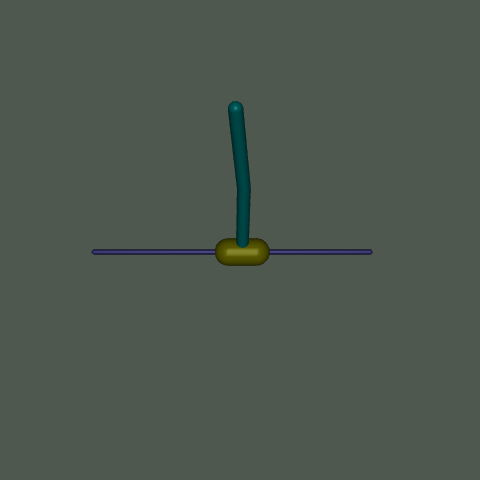

In [15]:
# test the optimal control inputs on the environment

frames = []  # frames to create animated png
frames.append(env.render())
for t in range(N-1):
    action = us[t,:]
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")